# Ball in Play Model

In [1]:
import pandas as pd
import numpy as np
from configparser import ConfigParser
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


In [2]:
# establish sql engine connection
parser = ConfigParser()
parser.read('nb.ini')
conn_string = parser.get('my_db', 'conn_string')
engine = create_engine(conn_string)

In [3]:
## fetch clustered data from postgresql database

sql1 = '''
    SELECT *
    FROM clustering
'''
df = pd.read_sql_query(sql1, engine)

In [4]:
df.shape

(3793167, 38)

## Non Ball in Play Outcomes

In [5]:
non_bip = df.loc[df['description']!='hit_into_play']

In [6]:
non_bip['description'].unique()

array(['foul', 'called_strike', 'ball', 'hit_by_pitch', 'swinging_strike',
       'blocked_ball', 'foul_bunt', 'foul_tip', 'missed_bunt',
       'swinging_strike_blocked', 'bunt_foul_tip', 'foul_pitchout'],
      dtype=object)

In [7]:
non_bip['e_delta_re'] = non_bip.groupby('description')['delta_run_exp'].transform('mean')

<ipython-input-7-040f997c7f75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_bip['e_delta_re'] = non_bip.groupby('description')['delta_run_exp'].transform('mean')


In [8]:
pd.set_option('display.max_columns', None)
non_bip.events.unique()

array(['none', 'strikeout', 'hit_by_pitch', 'walk', 'caught_stealing_2b',
       'strikeout_double_play', 'wild_pitch', 'stolen_base_2b',
       'other_out', 'caught_stealing_3b', 'caught_stealing_home',
       'pickoff_1b', 'pickoff_2b', 'pickoff_3b', 'catcher_interf',
       'field_out', 'passed_ball', 'pickoff_caught_stealing_home',
       'stolen_base_3b', 'ejection', 'pickoff_caught_stealing_2b',
       'pickoff_caught_stealing_3b', 'runner_double_play',
       'stolen_base_home', 'game_advisory'], dtype=object)

## Ball in Play Outcomes

In [9]:
bip = df.loc[df['description']=='hit_into_play']

In [10]:
bip.events.unique()

array(['sac_fly', 'field_out', 'double', 'field_error', 'single',
       'home_run', 'grounded_into_double_play', 'force_out',
       'fielders_choice', 'triple', 'sac_bunt', 'double_play',
       'fielders_choice_out', 'sac_fly_double_play',
       'sac_bunt_double_play', 'triple_play', 'catcher_interf',
       'game_advisory'], dtype=object)

In [11]:
# bip = bip[bip.launch_speed != 0]

In [12]:
bip['delta_run_exp'].describe()

count    662159.000000
mean          0.054928
std           0.535615
min          -1.539000
25%          -0.268000
50%          -0.152000
75%           0.309000
max           3.702000
Name: delta_run_exp, dtype: float64

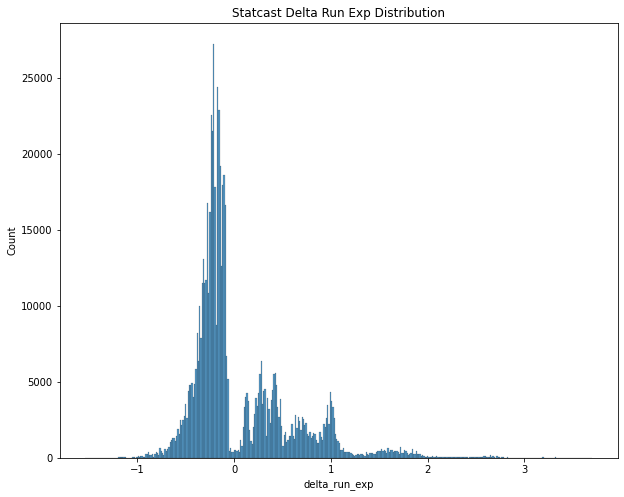

In [29]:
plt.figure(figsize=(10,8))
sns.histplot(data=bip, x="delta_run_exp")
plt.title('Statcast Delta Run Exp Distribution')
plt.show()

In [15]:
bip_5k = bip.sample(n=5000)
bip_10k = bip.sample(n=10000)
bip_25k = bip.sample(n=25000)

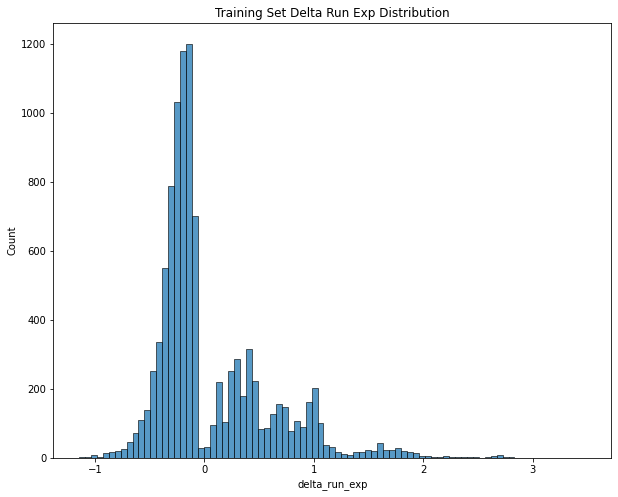

In [31]:
plt.figure(figsize=(10,8))
sns.histplot(data=bip_10k, x="delta_run_exp")
plt.title('Training Set Delta Run Exp Distribution')
plt.show()

In [32]:
from sklearn.model_selection import GridSearchCV

# split the data
X, y = bip_10k[['launch_speed', 'launch_angle']], bip_10k['delta_run_exp']

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=13, test_size=0.3)
    
print(X_train.shape)
print(X_test.shape)

# bring pipelines together for modeling
rf_reg = Pipeline(steps=[('scaler', StandardScaler()),
                        ('regressor', RandomForestRegressor(n_jobs=-1))])
print('rf_reg')
# set hyperparameter grid for tuning

param_dist = { 
          'regressor__n_estimators': [100, 200, 500],
          'regressor__max_depth':[None, 5, 8],
          'regressor__max_features': ['auto', 'sqrt', 'log2']
}

print('fitting model')

# rf_reg.fit(X_train, y_train)

# do search
search = GridSearchCV(rf_reg, 
param_dist, n_jobs=-1, scoring='neg_root_mean_squared_error')
search.fit(X_train, y_train)
search.best_params_

(7000, 2)
(3000, 2)
rf_reg
fitting model


{'regressor__max_depth': 8,
 'regressor__max_features': 'sqrt',
 'regressor__n_estimators': 500}

In [33]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_pred = search.best_estimator_.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('rmse: ', rmse)

r2 = r2_score(y_test, y_pred)
print('r2: ', r2)

mae = mean_absolute_error(y_test, y_pred)
print('mae: ', mae)

rmse:  0.43481805381076816
r2:  0.3270905590866906
mae:  0.3035229647346896


In [16]:
bip['e_delta_re'] = search.best_estimator_.predict(bip[['launch_speed','launch_angle']])

<ipython-input-16-117fa2f92d85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bip['e_delta_re'] = rf_reg.predict(bip[['launch_speed','launch_angle']])


In [17]:
bip.loc[bip['e_delta_re']>1.0]

,index,player_name,home_team,away_team,inning_topbot,p_throws,pitch_type,game_date,events,pitcher,batter,description,launch_speed,launch_angle,release_speed,release_pos_x,release_pos_y,release_pos_z,release_spin_rate,release_extension,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,effective_speed,pitch_name,spin_axis,delta_run_exp,pitcher_team,cat,cluster_id,cluster_name,e_delta_re
31,346,"Kluber, Corey",CLE,CHC,Top,R,SI,2016-11-02 00:00:00,home_run,446372,451594,hit_into_play,103.9,33.0,0.680214,-1.51,50.00,5.58,-0.192690,6.4,-0.997691,0.232074,0.126169,0.076795,6.750000,-134.980000,-4.520000,-12.380000,22.440000,-22.800000,94.4,Sinker,0.765035,0.967,CLE,rhp_mf,2,rhp_mf_2,1.427279
66,578,"Otero, Dan",CLE,CHC,Top,R,SI,2016-11-01 00:00:00,home_run,519096,608365,hit_into_play,108.0,23.0,0.298308,-1.30,50.00,5.43,-0.368044,6.8,-1.340581,0.179260,0.045524,0.055969,6.540000,-131.610000,-3.560000,-15.450000,24.620000,-23.980000,92.1,Sinker,0.997675,2.482,CLE,rhp_mf,4,rhp_mf_4,1.194216
80,850,"Bauer, Trevor",CHC,CLE,Bot,R,FT,2016-10-30 00:00:00,home_run,545333,592178,hit_into_play,104.5,23.0,0.563982,-0.93,50.00,5.58,-0.466488,6.4,-1.443448,1.037485,-0.518991,0.378763,4.580000,-134.060000,-4.910000,-17.040000,28.850000,-15.440000,92.2,2-Seam Fastball,0.576014,1.012,CLE,rhp_mf,2,rhp_mf_2,1.052802
108,1056,"Kluber, Corey",CHC,CLE,Bot,R,SI,2016-10-29 00:00:00,double,446372,519203,hit_into_play,104.1,25.0,0.829655,-1.68,50.00,5.51,0.028810,6.2,-1.249144,0.060429,-0.277056,0.014319,6.840000,-136.170000,-4.240000,-15.450000,26.010000,-24.540000,93.8,Sinker,0.503314,0.641,CLE,rhp_mf,1,rhp_mf_1,1.477792
477,4113,"Stroman, Marcus",TOR,CLE,Top,R,FT,2016-10-17 00:00:00,home_run,573186,435063,hit_into_play,109.5,29.0,1.045516,-1.35,50.00,5.35,0.868664,5.9,-0.837676,0.496143,0.022483,-0.308475,5.750000,-138.020000,-5.470000,-10.520000,35.100000,-20.150000,93.7,2-Seam Fastball,0.779575,1.037,TOR,rhp_mf,1,rhp_mf_1,1.227232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792583,704175,"Morejon, Adrian",SD,SF,Top,L,CH,2021-04-05 00:00:00,home_run,670970,573131,hit_into_play,106.2,25.0,-0.614947,1.32,54.23,5.95,-3.807445,6.3,1.528264,-0.111216,0.633081,0.108033,-4.088836,-123.725986,-3.342858,12.876829,25.637002,-25.176024,84.9,Changeup,-0.994309,0.924,SD,lhp_off,3,lhp_off_3,1.356751
3792592,704678,"Montgomery, Jordan",NYY,BAL,Top,L,CH,2021-04-05 00:00:00,field_out,656756,596748,hit_into_play,104.8,29.0,-1.030062,1.82,54.00,6.64,-1.438627,6.5,1.002500,1.116706,0.909578,0.534953,-3.655709,-119.903557,-5.278345,7.536033,25.664283,-16.210365,82.4,Changeup,-0.601728,-0.263,NYY,lhp_off,1,lhp_off_1,1.192754
3792762,709411,"Webb, Tyler",CIN,STL,Bot,L,CH,2021-04-04 00:00:00,home_run,643778,571980,hit_into_play,109.8,28.0,-1.810479,1.79,54.11,6.94,-1.853939,6.4,0.705328,0.654585,0.091607,-0.027332,-4.443941,-113.324271,-5.609197,4.610100,16.514271,-20.800596,78.7,Changeup,-0.398168,2.490,STL,lhp_off,3,lhp_off_3,1.701305
3792940,714551,"Heaney, Andrew",LAA,CWS,Top,L,CH,2021-04-02 00:00:00,home_run,571760,547989,hit_into_play,102.2,30.0,-0.648156,1.96,54.46,5.59,-0.586468,6.0,1.802576,0.245277,0.218335,-0.152285,-6.843093,-123.266817,-3.560512,15.798398,25.689740,-22.370387,84.2,Changeup,-0.805289,3.280,LAA,lhp_off,2,lhp_off_2,1.232245


In [18]:
frames = [bip, non_bip]

df_concat = pd.concat(frames)

In [19]:
df_concat['clust_e_delta_re_mean'] = df_concat.groupby(['batter', 'cluster_name'])['e_delta_re'].transform('mean')

In [20]:
df_concat_2 = df_concat.groupby(['pitcher', 'cluster_name']).size().unstack(fill_value=0).reset_index()

In [21]:
cols = ['lhp_cukc_0', 'lhp_cukc_1', 'lhp_cukc_2', 'lhp_cukc_3',
        'lhp_ff_0', 'lhp_ff_1', 'lhp_ff_2', 'lhp_ff_3',
        'lhp_mf_0', 'lhp_mf_1', 'lhp_mf_2', 'lhp_mf_3',
        'lhp_off_0', 'lhp_off_1', 'lhp_off_2', 'lhp_off_3',
        'lhp_slct_0', 'lhp_slct_1', 'lhp_slct_2', 'lhp_slct_3',
        'rhp_cukc_0', 'rhp_cukc_1', 'rhp_cukc_2', 'rhp_cukc_3', 'rhp_cukc_4',
        'rhp_ff_0', 'rhp_ff_1', 'rhp_ff_2', 'rhp_ff_3',
        'rhp_mf_0', 'rhp_mf_1', 'rhp_mf_2', 'rhp_mf_3', 'rhp_mf_4',
        'rhp_off_0', 'rhp_off_1', 'rhp_off_2', 'rhp_off_3',
        'rhp_slct_0', 'rhp_slct_1', 'rhp_slct_2', 'rhp_slct_3']

df_concat_2[cols] = df_concat_2[cols].div(df_concat_2[cols].sum(axis=1), axis=0)

In [22]:
cluster_sum = df_concat_2.melt(id_vars=["pitcher"], var_name="cluster_name_pitcher", value_name="value")

cluster_sum = cluster_sum[cluster_sum.value != 0]

In [23]:
df2 = df_concat[['batter', 'pitcher', 'pitcher_team', 'game_date', 'cluster_name', 'clust_e_delta_re_mean']].merge(cluster_sum, left_on=['pitcher', 'cluster_name'], right_on=['pitcher', 'cluster_name_pitcher'])


In [24]:
df2['score'] = df2['value'] * df2['clust_e_delta_re_mean']

In [25]:
df2['matchup_score'] = df2.groupby(['batter', 'pitcher'])['score'].transform('sum')

In [26]:
sql1 = '''
    SELECT *
    FROM player_lookup
'''
player_lookup = pd.read_sql_query(sql1, engine)

sql_pitching = '''
    SELECT distinct("IDfg"), max("G") as G, max("GS") as GS
    FROM pitching
    GROUP BY "IDfg", "Team"
'''

pitching = pd.read_sql_query(sql_pitching, engine)

sql_hitting = '''
    SELECT distinct("IDfg")
    FROM hitting  
'''

hitting = pd.read_sql_query(sql_hitting, engine)

In [27]:
player_lookup = player_lookup[['name_last', 'name_first', 'key_mlbam', 'key_fangraphs']]

df3 = df2.merge(player_lookup, how='left', left_on = 'pitcher', right_on = 'key_mlbam')

df3['pitcher_name'] = df3['name_last'] + ', ' + df3['name_first']

df3 = df3.merge(player_lookup, how='left', left_on='batter', right_on='key_mlbam')

df3['batter_name'] = df3['name_last_y'] + ', ' + df3['name_first_y']

df3 = df3.drop(columns=['name_last_x', 'name_first_x', 'name_last_y', 'name_first_y'])

df3 = df3.merge(pitching, how='left', left_on='key_fangraphs_x', right_on='IDfg')

df3 = df3.merge(hitting, how='left', left_on='key_fangraphs_y', right_on='IDfg')

df3['isStarter'] = ((df3['gs'] / df3['g']) > 0.8)

df3 = df3.dropna(subset=['g', 'gs'])

In [28]:
pitcher_df = df3[['pitcher_name', 'pitcher_team', 'game_date']].sort_values('game_date').groupby('pitcher_name').tail(1)
pitcher_df_2021 = pitcher_df.loc[pitcher_df['game_date']>'2021-01-01']

In [29]:
df3_2021 = df3.loc[df3['game_date']>'2021-03-01']
df3_2021_reco = df3_2021[['batter_name', 'pitcher_name', 'pitcher_team', 'matchup_score', 'isStarter']].merge(pitcher_df_2021, on='pitcher_name', how='inner').drop(columns=['pitcher_team_x', 'game_date']).rename(columns = {'pitcher_team_y':'pitcher_team'}).drop_duplicates()
df3_2021_reco

,batter_name,pitcher_name,matchup_score,isStarter,pitcher_team
0,"Grichuk, Randal","Kluber, Corey",0.009679,True,NYY
1,"Espinal, Santiago","Kluber, Corey",0.031792,True,NYY
3,"Springer, George","Kluber, Corey",0.103629,True,NYY
4,"Lowe, Nathaniel","Kluber, Corey",-0.005626,True,NYY
5,"Kiner-Falefa, Isiah","Kluber, Corey",-0.038098,True,NYY
...,...,...,...,...,...
715951,"Rosario, Eddie","Luetge, Lucas",-0.001468,False,NYY
715991,"Raleigh, Cal","Luetge, Lucas",-0.026305,False,NYY
716007,"Diaz, Lewin","Luetge, Lucas",-0.013012,False,NYY
716015,"Miller, Brad","Luetge, Lucas",-0.000465,False,NYY


In [30]:
df3_2021_reco.to_sql('bp_reco_df', engine, if_exists='replace', 
               chunksize= 100, method='multi')

In [31]:
import pandas as pd
from configparser import ConfigParser
from sqlalchemy import create_engine

# establish sql engine connection
parser = ConfigParser()
parser.read('nb.ini')
conn_string = parser.get('my_db', 'conn_string')
engine = create_engine(conn_string)

# fetch statcast data from postgresql database

sql1 = '''
        SELECT *
        FROM bp_reco_df
    '''
bp_reco_df = pd.read_sql_query(sql1, engine)

def bp_reco(batter, pitcher_tm, df):
    df_reco = df.loc[df['batter_name']==batter]
    df_reco_team = df_reco.loc[df_reco['pitcher_team']==pitcher_tm]

    return df_reco_team.sort_values(by=['matchup_score'])

yoyo = bp_reco('Moncada, Yoan', 'DET', bp_reco_df)

yoyo.loc[yoyo['isStarter']==False]

,index,batter_name,pitcher_name,matchup_score,isStarter,pitcher_team
74602,632766,"Moncada, Yoan","Alexander, Tyler",-0.044056,False,DET
74494,631813,"Moncada, Yoan","Soto, Gregory",-0.005018,False,DET
66784,563913,"Moncada, Yoan","Krol, Ian",-0.004176,False,DET
20747,199603,"Moncada, Yoan","Hutchison, Drew",-0.002986,False,DET
59193,496524,"Moncada, Yoan","Lange, Alex",0.004058,False,DET
32686,294525,"Moncada, Yoan","Foley, Jason",0.006832,False,DET
25077,233131,"Moncada, Yoan","Garcia, Bryan",0.010291,False,DET
25415,234980,"Moncada, Yoan","Cisnero, Jose",0.012709,False,DET
29643,271825,"Moncada, Yoan","Funkhouser, Kyle",0.012914,False,DET
52639,454953,"Moncada, Yoan","Farmer, Buck",0.022628,False,DET
